# <div align="center"><b> Swin transformer V2 </b></div>

<div align="right">

<!-- [![Binder](http://mybinder.org/badge.svg)](https://mybinder.org/) -->
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange?logo=Jupyter)](https://nbviewer.org/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

</div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻


Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:

```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:

```powershell
poetry install
Invoke-Expression (poetry env activate)
```

> 📝 <em><font color='Gray'>Nota:</font></em> Para agregar `pytorch` utilizando Poetry, se utiliza el siguiente comando:
> ```bash
> # Más info: https://github.com/python-poetry/poetry/issues/6409
> poetry source add --priority explicit pytorch_gpu https://download.pytorch.org/whl/cu128 # Seleccionar la wheel adecuada para tu GPU
> poetry add --source pytorch_gpu torch torchvision 
> ```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [ ]:
# Recarga automática de módulos en Jupyter Notebook
%reload_ext autoreload
%autoreload 2

import random
from loguru import logger

import pandas as pd

# PyTorch
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# NumPy y utilidades
import numpy as np
from functools import partial

# Evaluación
import evaluate

# Modelos y procesamiento de imágenes (Transformers)
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    # Swinv2ForImageClassification,  # Descomentar si se usa explícitamente
)

# # Transformaciones de imágenes (Torchvision)
# from torchvision.transforms import (
#     Compose,
#     Normalize,
#     ToTensor,
#     RandomResizedCrop,
#     RandomHorizontalFlip,
#     Resize,
#     CenterCrop,
# )

from PIL import Image

# Módulos propios
from vision_transformer.plots import show_image_grid
from vision_transformer.dataset import load_huggingface_dataset
from vision_transformer.features import SwinV2Transforms
from vision_transformer.config import RANDOM_SEED, MODELS_DIR

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [74]:
random.seed(RANDOM_SEED)  # Establece la semilla para la reproducibilidad.

BATCH_SIZE = 32

# Checkpoints a utilizar
CHECKPOINT = "microsoft/swinv2-tiny-patch4-window8-256"
# CHECKPOINT = "microsoft/swinv2-base-patch4-window8-256"
# CHECKPOINT = "microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft"

# Optimizaciones
# # torch.set_float32_matmul_precision('highest') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'más alta'.
# torch.set_float32_matmul_precision('high') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'alta'.
# # torch.set_float32_matmul_precision('medium') # Optimización: Establece la precisión de las multiplicaciones de matrices de punto flotante de 32 bits en 'media'.
# # torch.backends.cudnn.benchmark = True # Optimización: Para redes CNN (pero como se usa una capa convolucional, se establece en True).

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.
print(f"Dispositivo actual: {DEVICE}")

Dispositivo actual: cuda


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | *Fine-tuning* del modelo swimv2 sobre el dataset EuroSAT                                                                       |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | <small>Análisis exploratorio del proceso de *fine-tuning* del swimv2 sobre el EuroSAT<br/>- *Tarea:* `Clasificación`<br/>- *Modelo*: `swimv2`<br/> - *Dataset*: `EuroSAT` </small>|
<!-- | **Autor** | <small>[Nombre] ([correo]) </small>                                                                                                 | -->

</div>

## Tabla de contenidos
0. [Pasos previos](#pasos-previos)
1. [Carga de datos](#carga-de-datos)
2. [Carga del modelo](#carga-del-modelo)
3. [Preprocesamiento del dataset](#preprocesamiento)
4. [Definicion de las metricas de evaluacion](#metricas)
5. [Entrenamiento del modelo](#entrenamiento)
6. [Resultados](#resultados)

## 0. Pasos previos <a id="pasos-previos"></a>

In [75]:
# TODO: Ejecutar perfect y descargar el dataset.

## 1. Carga de datos <a name="carga-de-datos"></a>

In [76]:
dataset = load_huggingface_dataset()

2025-06-13 12:25:47.892 | INFO     | vision_transformer.dataset:load_huggingface_dataset:426 - Cargando el dataset procesado...
2025-06-13 12:25:48.416 | INFO     | vision_transformer.dataset:load_huggingface_dataset:438 - El dataset contiene múltiples conjuntos (train, test, val). Cargando todos...


Resolving data files:   0%|          | 0/24300 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2700 [00:00<?, ?it/s]

In [77]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2700
    })
})


In [78]:
# Obtenemos el número de clases y las etiquetas
labels = dataset["train"].features["label"].names
id2label = {id: label for id, label in enumerate(dataset["train"].features["label"].names)}
label2id = {label: id for id, label in id2label.items()}

print("Cantidad de clases:", len(id2label), "\n")
for k, v in id2label.items():
    print(f"- id {k}: {v}")

Cantidad de clases: 10 

- id 0: AnnualCrop
- id 1: Forest
- id 2: HerbaceousVegetation
- id 3: Highway
- id 4: Industrial
- id 5: Pasture
- id 6: PermanentCrop
- id 7: Residential
- id 8: River
- id 9: SeaLake


In [79]:
# Mostramos como está compuesta una imagen del dataset
print(dataset['train'][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x16BFE372C40>, 'label': 0}


In [80]:
# TODO: Comentar este bloque de prueba cuando se use todo el dataset.
dataset["train"] = dataset["train"].shuffle(seed=RANDOM_SEED).select(range(100))
dataset["test"] = dataset["test"].shuffle(seed=RANDOM_SEED).select(range(80))

## 2. Carga del modelo <a name="carga-del-modelo"></a>

El Swin Transformer es un modelo de visión por computadora que utiliza una arquitectura jerárquica basada en ventanas deslizantes para procesar imágenes de manera eficiente. Es conocido por su capacidad para capturar tanto características locales como globales, lo que lo hace adecuado para tareas de clasificación de imágenes y detección de objetos.

Su publicación original fue en 2021 por Liu et al. ([Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/pdf/2103.14030)) y desde entonces ha sido ampliamente utilizado en diversas aplicaciones de visión por computadora.

Su enfoque innovador se basa en dividir la imagen en ventanas deslizantes y aplicar transformaciones dentro de estas ventanas, lo que permite una mayor eficiencia computacional y una mejor captura de características a diferentes escalas, como puede observarse en la siguiente imagen:

<div align="center"><img src="../resources/swin-transformer-original.jpg" width="600" alt="Figura 1: Arquitectura del Swin Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF"></div>
<div align="center"><small><em>Figura 1: Arquitectura del Swin Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF</em></small></div>

Su segunda versión, publicada en el artículo [Swin Transformer V2: Scaling Up Capacity and Resolution](https://arxiv.org/pdf/2111.09883), donde se hacen varias mejoras, entre las cuales se nombran:
1. Una configuración *res-post-norm* para reemplazar la configuración *prenorm* anterior.
2. Una atención cosenoidal escalada (*scaled cosine attention*) para reemplazar la atención original basada en producto punto (*dot product*, la operación normal en los transformers).
3. El remplazo del enfoque parametrizado anterior en base a un enfoque basado en un posicionamiento relativo espaciado (*log-spaced continuous relative position*).

En donde las primeras dos adaptaciones permiten que sea más fácil que el modelo escale en capacidad y la tercera permite una mejor transferencia en diferentes resoluciones de ventanas.

Un resumen de las mejoras se puede observar en la siguiente imagen:

<div align="center"><img src="../resources/siwnv2-diferences.png" width="600" alt="Figura 1: Arquitectura del Swin Transformer - Obtenida de https://github.com/rishigami/Swin-Transformer-TF"></div>
<div align="center"><small><em>Figura 2: Diferencias de Swin y SwinV2 - Obtenida de https://sh-tsang.medium.com/review-swin-transformer-v2-scaling-up-capacity-and-resolution-401c28b02df8</em></small></div>

In [81]:
print(f"Usando el modelo: {CHECKPOINT}")

Usando el modelo: microsoft/swinv2-tiny-patch4-window8-256


In [82]:
# Cargamos el modelo.
model = AutoModelForImageClassification.from_pretrained(
    CHECKPOINT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Ignora tamaños de pesos que no coinciden (útil si se cambia el número de clases).
)

print(model)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias

## 3. Preprocesamiento del dataset <a name="preprocesamiento-del-dataset"></a>

In [83]:
# Procesador
image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT, use_fast=True)
print(image_processor)

ViTImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 256,
    "width": 256
  }
}



Transformaciones aplicadas:

In [84]:
transforms = SwinV2Transforms(image_processor=image_processor)
print(transforms.transforms_to_string())

Transformaciones de entrenamiento:
  - RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
  - RandomHorizontalFlip(p=0.5)
  - ToTensor()
  - Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Transformaciones de validacion:
  - Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
  - CenterCrop(size=(256, 256))
  - ToTensor()
  - Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


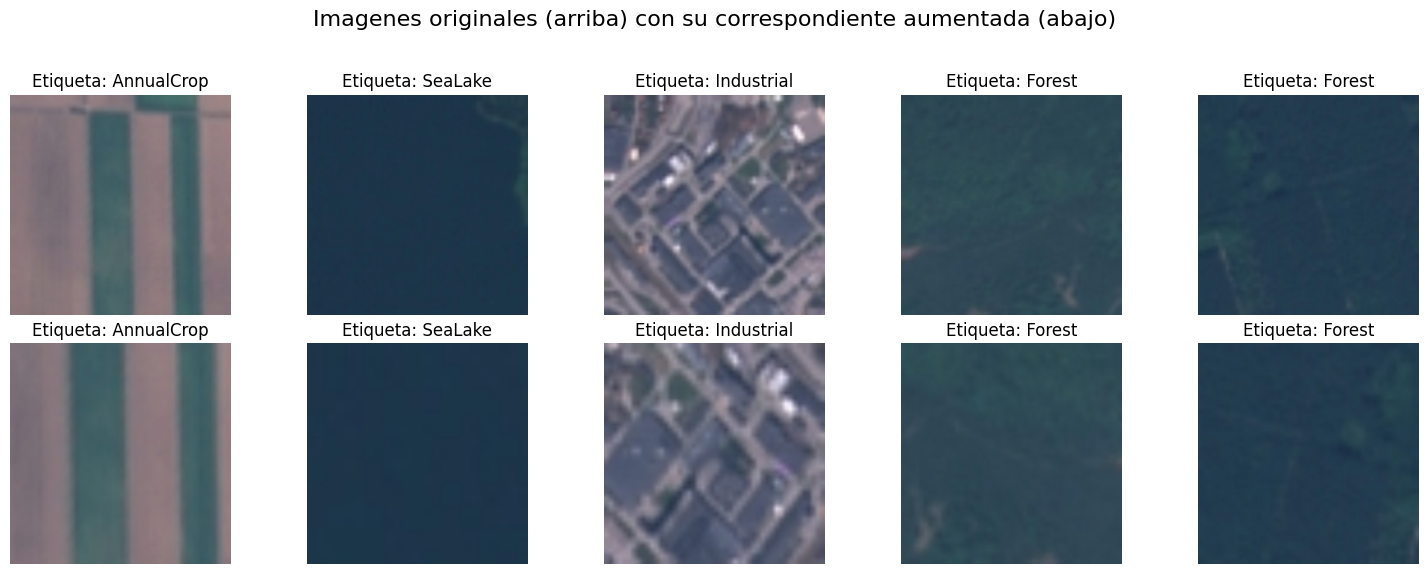

In [85]:
random_idx = random.sample(range(len(dataset["train"])), 5)
plot_subset = dataset["train"].select(random_idx)

raw_plot_subset = plot_subset.with_transform(lambda x: transforms(x, train=False))
raw_dataloader = DataLoader(raw_plot_subset, batch_size=5, shuffle=False)

aug_plot_subset = plot_subset.with_transform(lambda x: transforms(x, train=True))
aug_dataloader = DataLoader(aug_plot_subset, batch_size=5, shuffle=False)

# Get and unnormalize raw images
raw_batch = next(iter(raw_dataloader))
raw_images = [TF.to_pil_image(transforms.unnormalize(img)) for img in raw_batch["pixel_values"]]

# Get and unnormalize augmented images
aug_batch = next(iter(aug_dataloader))
aug_images = [TF.to_pil_image(transforms.unnormalize(img)) for img in aug_batch["pixel_values"]]

plot_labels = [id2label[int(x)] for x in raw_batch["label"]] * 2

# Plot images
show_image_grid(
    data={"images": raw_images + aug_images, "labels": plot_labels},
    title="Imagenes originales (arriba) con su correspondiente aumentada (abajo)",
    num_cols=5,
)

In [87]:
# Aplicamos las transformaciones
dataset["train"].set_transform(partial(transforms, train=True))
dataset["test"].set_transform(partial(transforms, train=False))

# Mostramos un ejemplo de la estructura.
print(dataset["train"][0])
print(dataset["test"][0]["pixel_values"].shape)

{'label': 0, 'pixel_values': tensor([[[ 1.3413,  1.3413,  1.3413,  ..., -0.5424, -0.5424, -0.5424],
         [ 1.3413,  1.3413,  1.3413,  ..., -0.5424, -0.5424, -0.5424],
         [ 1.3413,  1.3413,  1.3413,  ..., -0.5424, -0.5424, -0.5424],
         ...,
         [ 1.5639,  1.5639,  1.5639,  ...,  0.7248,  0.7248,  0.7248],
         [ 1.5639,  1.5639,  1.5639,  ...,  0.7248,  0.7248,  0.7248],
         [ 1.5639,  1.5639,  1.5639,  ...,  0.7248,  0.7248,  0.7248]],

        [[ 0.9055,  0.9055,  0.9055,  ..., -0.4076, -0.4076, -0.4076],
         [ 0.9055,  0.9055,  0.9055,  ..., -0.4076, -0.4076, -0.4076],
         [ 0.9055,  0.9055,  0.9055,  ..., -0.4076, -0.4076, -0.4076],
         ...,
         [ 1.1506,  1.1506,  1.1506,  ...,  0.3452,  0.3452,  0.3452],
         [ 1.1506,  1.1506,  1.1506,  ...,  0.3452,  0.3452,  0.3452],
         [ 1.1506,  1.1506,  1.1506,  ...,  0.3452,  0.3452,  0.3452]],

        [[ 0.9145,  0.9145,  0.9145,  ..., -0.0964, -0.0964, -0.0964],
         [ 0.914

## 4. Definición de las métricas de evaluación <a name="metrics"></a>

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## 5. Entrenamiento del modelo <a name="entrenamiento"></a>

In [ ]:
data_collator = DefaultDataCollator()

callback_list = [
    EarlyStoppingCallback(
        early_stopping_patience=5
    )
]

training_args = TrainingArguments(
    output_dir=MODELS_DIR / "swimv2",  
    overwrite_output_dir=True,  
    eval_strategy="epoch",  
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,                                        
    eval_accumulation_steps=4, 
    learning_rate=5e-5,  
    num_train_epochs=20,  
    warmup_ratio=0.1,   
    save_strategy="best", 
    save_total_limit=2, 
    logging_strategy="epoch",  
    seed=RANDOM_SEED,  
    remove_unused_columns=False,  
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,   
    args=training_args,
    data_collator=data_collator,   
    train_dataset=dataset['train'], 
    eval_dataset=dataset['test'],   
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    callbacks=callback_list, 
)

In [90]:
logger.info("Iniciando entrenamiento del modelo...")
trainer.train()  # Inicia el entrenamiento del modelo.
logger.info("Entrenamiento finalizado. Guardando el modelo...")

2025-06-13 12:26:44.815 | INFO     | __main__:<module>:1 - Iniciando entrenamiento del modelo...


Epoch,Training Loss,Validation Loss,Accuracy
1,2.278700,2.261359,0.200000
2,2.008800,2.013103,0.412500
3,1.835000,1.713426,0.537500
4,1.243200,1.339288,0.637500
5,1.113600,1.084822,0.675000
6,0.757600,0.892116,0.687500
7,0.599000,0.804441,0.737500
8,0.418400,0.677156,0.762500
9,0.341100,0.724317,0.725000
10,0.342500,0.609184,0.750000


2025-06-13 12:27:09.375 | INFO     | __main__:<module>:3 - Entrenamiento finalizado. Guardando el modelo...


In [102]:
history = pd.DataFrame(trainer.state.log_history)
history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.2787,15.708569,0.000019,1.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,4,2.261359,0.2000,0.9606,83.279,3.123,NaN,NaN,NaN,NaN,NaN
2,2.0088,17.143681,0.000044,2.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,2.0,8,2.013103,0.4125,0.2224,359.714,13.489,NaN,NaN,NaN,NaN,NaN
4,1.8350,24.446362,0.000048,3.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,3.0,12,1.713426,0.5375,0.2196,364.232,13.659,NaN,NaN,NaN,NaN,NaN
6,1.2432,23.175604,0.000045,4.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,16,1.339288,0.6375,0.2259,354.068,13.278,NaN,NaN,NaN,NaN,NaN
8,1.1136,35.343594,0.000042,5.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,5.0,20,1.084822,0.6750,0.2165,369.461,13.855,NaN,NaN,NaN,NaN,NaN


## 6. Resultados <a name="resultados"></a>

In [ ]:
# Evaluar el modelo.
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

<!-- TODO: Gráfico de evolución de la pérdida -->

Original DataFrame head:
     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  2.2787  15.708569       0.000019    1.0     4        NaN            NaN   
1     NaN        NaN            NaN    1.0     4   2.261359         0.2000   
2  2.0088  17.143681       0.000044    2.0     8        NaN            NaN   
3     NaN        NaN            NaN    2.0     8   2.013103         0.4125   
4  1.8350  24.446362       0.000048    3.0    12        NaN            NaN   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  \
0           NaN                      NaN                    NaN   
1        0.9606                   83.279                  3.123   
2           NaN                      NaN                    NaN   
3        0.2224                  359.714                 13.489   
4           NaN                      NaN                    NaN   

   train_runtime  train_samples_per_second  train_steps_per_second  \
0            NaN                 

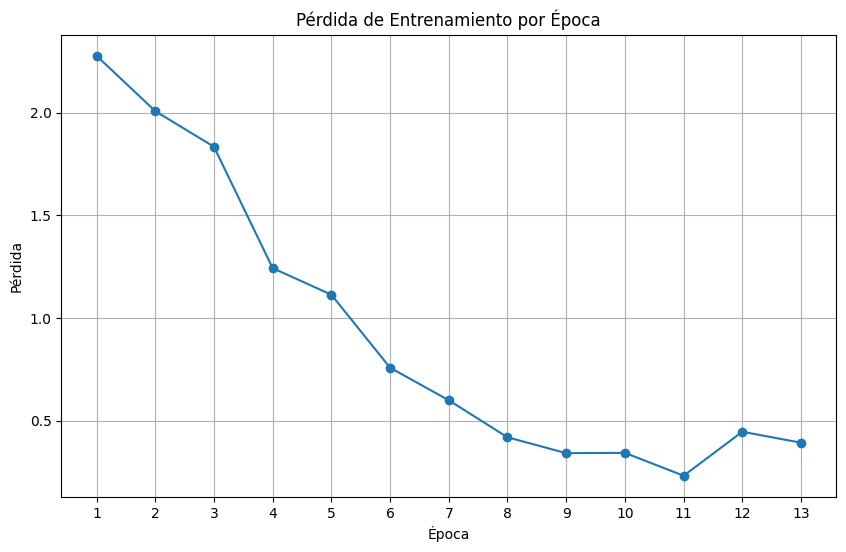

In [ ]:
# Display the first few rows and info to confirm data loading
from matplotlib import pyplot as plt

# Filter for training data (rows where 'loss' is not NaN)
training_history = history.dropna(subset=['loss']).copy()

# Ensure 'epoch' and 'loss' are numeric
training_history['epoch'] = pd.to_numeric(training_history['epoch'])
training_history['loss'] = pd.to_numeric(training_history['loss'])

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(training_history['epoch'], training_history['loss'], marker='o', linestyle='-')
plt.title('Pérdida de Entrenamiento por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)
plt.xticks(training_history['epoch'].unique()) # Ensure x-axis ticks are at each epoch
plt.savefig('training_loss_plot.png')

print("Training loss plot saved as training_loss_plot.png")